<a href="https://colab.research.google.com/github/Hrithik2212/Regression-CNN---Facial-Key-Point-Detection/blob/main/00_Facial_Key_Point_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Key Point Detection with PyTorch
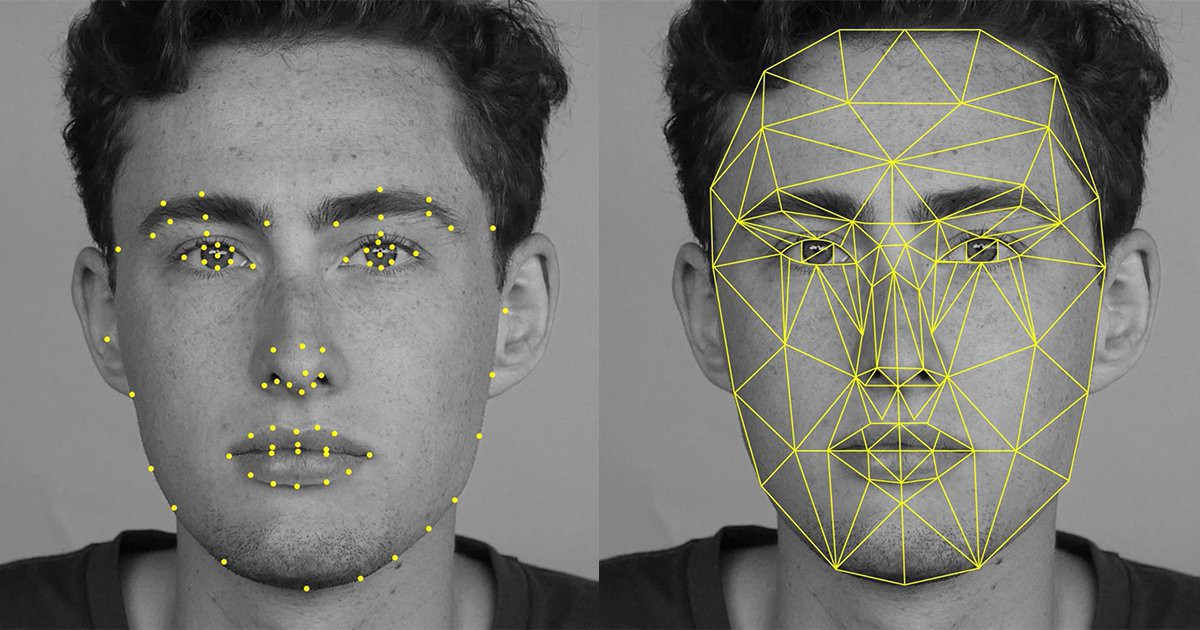

In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset,DataLoader,Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import cluster

In [2]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Data Wrangling 


In [3]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6043, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6043 (delta 0), reused 1 (delta 0), pack-reused 6038
Receiving objects: 100% (6043/6043), 329.52 MiB | 29.83 MiB/s, done.
Resolving deltas: 100% (153/153), done.
Checking out files: 100% (5805/5805), done.
